In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf



2024-01-05 06:58:37.454691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 06:58:37.454725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 06:58:37.455563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 06:58:37.461438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Load data
file_path = './Acc_pred_revised.xlsx'
data = pd.read_excel(file_path)

data.isna().mean()
data.head()

,Unnamed: 0,No.,Crash_Time_Cat,Week Day,Crash Type,Causes of Crash,Accident Severity Level,Direction,Geometrical Condition Type,Road Surface Conditions,...,Maufactured_Year_Cat,Vehicle Ownership,Driver_Age_Cat,Sex,Marital Status,License Level,Driving License Issuing Region,Driver_Exp_Cat,Driver Education Level,Driver Relationship with Vehicle
0,0,1,C,Sunday,Car Overthrow,Driver Error,Light Injury,To Adama,Straight,Dry,...,D,Private,B,M,Married,Hizbe 1,Oromia,A,Primary School,Employee
1,1,2,B,Tuesday,Other,Other,No Injury,To Addis Ababa,Straight,Dry,...,D,Private,B,M,Married,Hizbe 1,Oromia,A,Primary School,Employee
2,2,3,A,Tuesday,Car Overthrow,Vechile Defect,Light Injury,Toll Station,Straight,Dry,...,D,Private,B,M,Married,Hizbe 1,Oromia,A,Primary School,Employee
3,3,4,A,Monday,Other,Other,No Injury,To Adama,Straight,Dry,...,D,Private,B,M,Married,Hizbe 1,Oromia,A,Primary School,Employee
4,4,5,C,Friday,Crash with fixed obstacle,Driver Error,Light Injury,To Addis Ababa,Straight,Dry,...,D,Private,B,M,Married,Hizbe 1,Oromia,A,Primary School,Employee


In [3]:
from sklearn.impute import SimpleImputer
object_columns = data.select_dtypes(include=['object']).columns
imputer = SimpleImputer(strategy='most_frequent')
data[object_columns] = imputer.fit_transform(data[object_columns])



In [4]:
data.isna().sum()
data.columns.to_list()
dropped_columns = ['Crash_Time_Cat','Marital Status','No. ',
 'Week Day',
 'Direction',
 'Weather Condition',
 'Light Condition',
 'Maufactured_Year_Cat',
 'Vehicle Ownership',
 'Driver_Age_Cat',
 'Sex',
 'Driving License Issuing Region',
 'Driver Education Level',
 'Driver Relationship with Vehicle']
data = data.drop(dropped_columns,axis=1)

In [5]:
data['Vehicle_Type_Cat'] = data['Vehicle_Type_Cat'].str.replace('!','1')
data['Vehicle_Type_Cat'] = data['Vehicle_Type_Cat'].str.replace('-','')
data['Vehicle_Type_Cat'].unique()

array(['V1', 'V3', 'V4', 'V5', 'V2', 'V7', 'V6', 'v3', 'v1', 'v4', 'v7',
       'v6', 'v2'], dtype=object)

In [6]:
data['License Level'] = data['License Level'].str.replace('HIZEBE 1','HIZBE 1')
data['License Level'] = data['License Level'].str.replace('HIZEBE 2','HIZBE 2')
data['License Level'] = data['License Level'].str.replace('D/CHENET 1','D/CHENET')


In [7]:
def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [8]:
# {column: len(data[column].unique()) for column in data.columns}

In [9]:
data = onehot_encode(
    data,
    columns=['Crash Type', 'Causes of Crash', 'Geometrical Condition Type', 'Vehicle_Type_Cat', 'License Level', 'Driver_Exp_Cat'],
    prefixes=['CTC', 'WD', 'CT', 'COC', 'DIR', 'GCT']
)


In [10]:
data

,Unnamed: 0,Accident Severity Level,Road Surface Conditions,CTC_Car Overthrow,CTC_Crash with Vehicle,CTC_Crash with fixed obstacle,CTC_Other,CTC_Other,WD_Driver Error,WD_Other,...,DIR_level 2,DIR_level 3,DIR_level 4,DIR_level 5,DIR_other country,GCT_A,GCT_B,GCT_C,GCT_D,GCT_a
0,0,Light Injury,Dry,True,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,1,No Injury,Dry,False,False,False,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,2,Light Injury,Dry,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,3,No Injury,Dry,False,False,False,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False
4,4,Light Injury,Dry,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762,3762,No Injury,Dry,False,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3763,3763,No Injury,Dry,False,False,False,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3764,3764,Serious Injury,Dry,False,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3765,3765,No Injury,Dry,False,False,False,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False


In [11]:
def get_binary_column(df, column):
    if column == 'Road Surface Conditions':
        return df[column].apply(lambda x: 1 if x == 'DRY' else 0)
    # elif column == 'Sex':
    #     return df[column].apply(lambda x: 1 if x == 'M' else 0)
    # elif column == 'Light Condition':
    #     return df[column].apply(lambda x: 1 if x == 'DAYLIGHT' else 0)

In [12]:
data['Road Surface Conditions'] = get_binary_column(data, 'Road Surface Conditions')
# data['Sex'] = get_binary_column(data, 'Sex')
# data['Light Condition'] = get_binary_column(data, 'Light Condition')

In [13]:
data['Accident Severity Level'].unique()

array(['Light Injury', 'No Injury', 'Serious Injury', 'Fatal',
       'serious Injury'], dtype=object)

In [14]:
def map_accident_level(value):
    value = value.upper()
    if value == 'NO INJURY':
        return 0
    elif value == 'LIGHT INJURY':
        return 1
    elif value == 'SERIOUS INJURY':
        return 2
    else:
        return 3

def get_accident_level(df, column):
    if column == 'Accident Severity Level':
        return df[column].apply(map_accident_level)


In [15]:
data['Accident Severity Level'].unique() 

array(['Light Injury', 'No Injury', 'Serious Injury', 'Fatal',
       'serious Injury'], dtype=object)

In [16]:
data['Accident Severity Level'] = get_accident_level(data, 'Accident Severity Level')

# Test and Train data separation

In [17]:
data.to_csv('data.csv', index=False)

In [18]:
Y = data['Accident Severity Level'].copy()
X = data.drop('Accident Severity Level', axis=1).copy()


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Get the object columns
object_columns = X.select_dtypes(include=['object']).columns

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Iterate over each object column and encode the classes
for column in object_columns:
  X[column] = label_encoder.fit_transform(X[column])


In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Training

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load your data
# X = ...
# Y = ...

# Data preprocessing steps
# ...

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100}%")


Accuracy: 90.45092838196287%


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=100)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3013, 70), (754, 70), (3013,), (754,))

In [24]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

In [25]:
pd.DataFrame(y_train_encoded).head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0


In [26]:
import numpy as np
from sklearn.metrics import f1_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Define the model
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l2

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # ReLU activation
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # ReLU activation
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),  # ReLU activation
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),  # ReLU activation
    Dense(4, activation='softmax')  # Output layer for 4 classes with softmax
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)


# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,  
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")
# Predict probabilities for the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")

Epoch 1/50


2024-01-05 06:58:41.147948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-05 06:58:41.155344: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-05 06:58:41.155558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

95/95 [==============================] - 4s 7ms/step - loss: 1.7017 - accuracy: 0.2715 - val_loss: 1.4213 - val_accuracy: 0.3700
Epoch 2/50
95/95 [==============================] - 0s 5ms/step - loss: 1.3870 - accuracy: 0.4235 - val_loss: 1.1814 - val_accuracy: 0.6645
Epoch 3/50
95/95 [==============================] - 0s 5ms/step - loss: 1.1705 - accuracy: 0.5828 - val_loss: 0.9741 - val_accuracy: 0.7719
Epoch 4/50
95/95 [==============================] - 0s 5ms/step - loss: 1.0139 - accuracy: 0.6804 - val_loss: 0.8219 - val_accuracy: 0.8143
Epoch 5/50
95/95 [==============================] - 0s 5ms/step - loss: 0.8874 - accuracy: 0.7332 - val_loss: 0.7247 - val_accuracy: 0.8316
Epoch 6/50
95/95 [==============================] - 0s 5ms/step - loss: 0.8061 - accuracy: 0.7597 - val_loss: 0.6568 - val_accuracy: 0.8422
Epoch 7/50
95/95 [==============================] - 0s 5ms/step - loss: 0.7296 - accuracy: 0.7859 - val_loss: 0.6085 - val_accuracy: 0.8475
Epoch 8/50
95/95 [=============

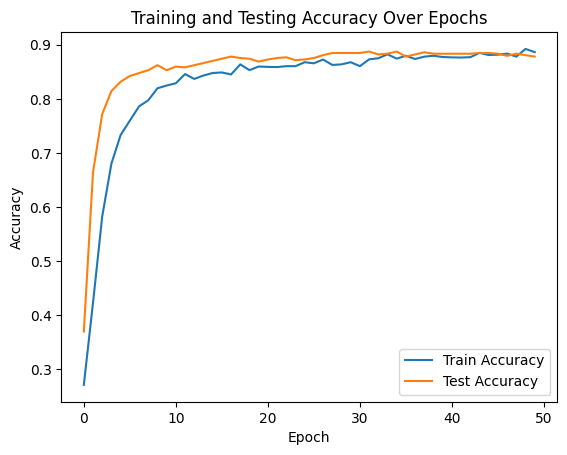

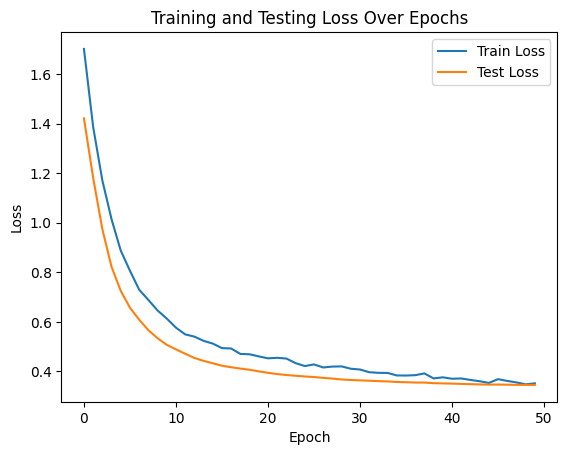

In [27]:
import matplotlib.pyplot as plt
# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy Over Epochs')
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss Over Epochs')
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

24/24 [==============================] - 0s 1ms/step


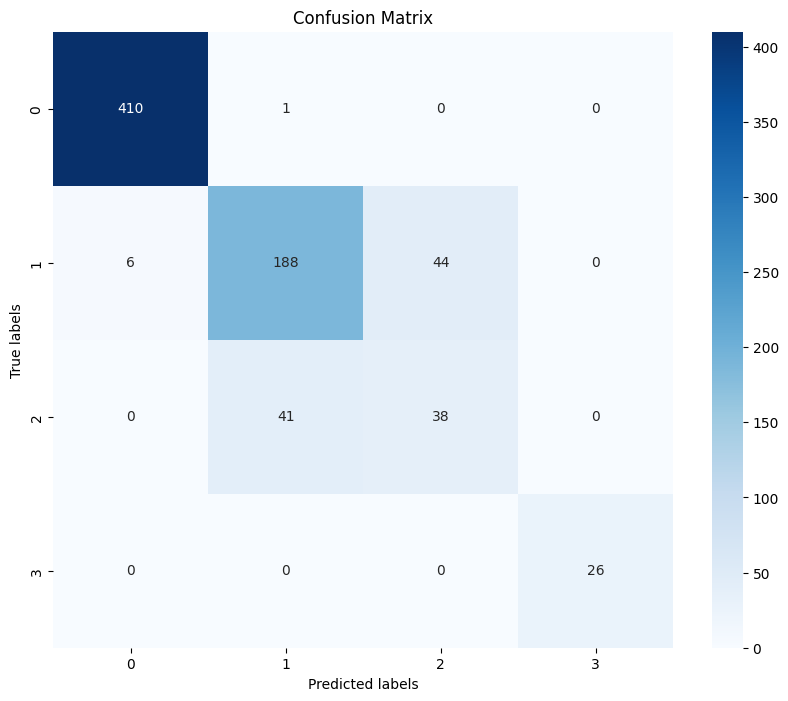

In [29]:
# Predict probabilities for the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()